# CS246 - Colab 6
## node2vec

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!pip install nodevectors

  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17950 sha256=e58325b15e75c772277ad980a3c999f1339022bde2501087c7a2e0926e598563
  Stored in directory: /root/.cache/pip/wheels/6e/6a/11/ac8620f101db6248c3cd436636eb17f6f7430cd1ac3a3068dc
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17632 sha256=f8fa4a657fe1d22b69a08f9744d2bc098e44657362c3aeaa14bc96860acccda8
  Stored in directory: /root/.cache/pip/wheels/3d/0a/58/36a63805f1cd719cbcc5a3c4c109604985a809e7d81bac1649
Successfully built nodevectors csrgraph


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [2]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example

In the example below, we will try to reproduce the plot in slide 8 of [CS246 - Lecture 12](http://web.stanford.edu/class/cs246/slides/12-graphs2.pdf).

In [70]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(1, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.03
Training W2V... Done, T=0.42


In [71]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

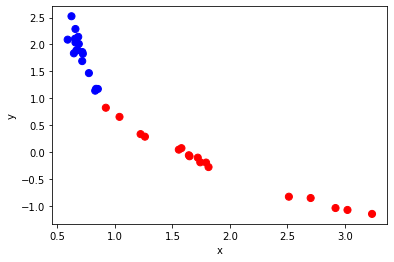

In [72]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

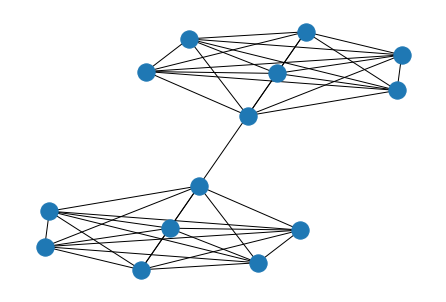

In [73]:
toy_barbell = nx.barbell_graph(7, 0)
nx.draw_kamada_kawai(toy_barbell)




Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [89]:
# YOUR CODE HERE
n2v_new = Node2VecNew(1, 1, 10)
n2v_new.fit(toy_barbell)

Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.02
Training W2V... Done, T=0.16


Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containing the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [90]:
# YOUR CODE HERE
import math
def cosine_sim(u, v):
  u_norm, v_norm, sum = 0, 0, 0
  for i in range(len(u)):
    u_norm += u[i]*u[i]
    v_norm += v[i]*v[i]
    sum += u[i]*v[i]

  return sum/(math.sqrt(u_norm)*math.sqrt(v_norm))

def get_cosinesim_list(G, n):
  embeddings = []
  for node in G.nodes:
    embedding = list(n2v_new.predict(node))
    embeddings.append(embedding)

  return [cosine_sim(embeddings[n], embeddings[i]) for i in G.nodes]

get_cosinesim_list(toy_barbell, 1)

[0.9964918564553241,
 1.0000000000000002,
 0.9965190034177295,
 0.9981440294482988,
 0.9962821489087867,
 0.9967833598291693,
 0.9966779849711067,
 0.3851123744725245,
 0.33180921121414325,
 0.33585246620821047,
 0.3465386404282814,
 0.31083347318076976,
 0.3443520087328309,
 0.3197197727830022]

Generate another barbell graph, this time adding a path of length 51 between the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.09
Training W2V... Done, T=0.72


[0.9979292265425798,
 1.0000000000000002,
 0.9987968066349183,
 0.9986029463365693,
 0.9982835667966187,
 0.9992217986887554,
 0.9530597708625916,
 0.7736347047982136,
 0.6420616832355982,
 0.5093524122559345,
 0.3759262299198671,
 0.29273440276702023,
 0.2614362679671202,
 0.2494971738393041,
 0.235417609204965,
 0.2193476933199582,
 0.20952280925400668,
 0.2236769935613379,
 0.2055706827617445,
 0.19869127998647115,
 0.21985802093166776,
 0.24659440139337202,
 0.2834429105194813,
 0.3209394835995558,
 0.35229837490510296,
 0.3480084004519576,
 0.3864279182536198,
 0.37690351231796154,
 0.3741926093231368,
 0.3564261514313035,
 0.3891397642623834,
 0.41711060716982734,
 0.44440513326221737,
 0.41106805855574907,
 0.3635724773405246,
 0.2851057866176852,
 0.18073546020064432,
 0.1412757271384268,
 0.08076804358617952,
 0.09905043009677006,
 0.13610821770474962,
 0.2408136002758917,
 0.32326383009682336,
 0.3708010048729072,
 0.4302235235811695,
 0.4503696557195755,
 0.43897923415716444

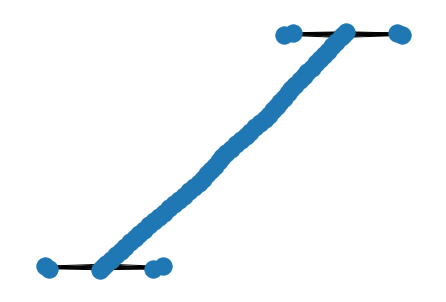

In [92]:
# YOUR CODE HERE
another = nx.barbell_graph(7, 52)
nx.draw_kamada_kawai(another)
n2v_new.fit(another)
get_cosinesim_list(another, 1)

Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!
